In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from librosa import display
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
from google.colab import drive
from sklearn.preprocessing import LabelBinarizer
warnings.filterwarnings('ignore', category=UserWarning)

from sklearn.metrics import classification_report

In [3]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd drive/MyDrive/ESC50/ESC50-Mas/ #Only use this if you have not cloned the ESC database to drive yet
!git clone https://github.com/karolpiczak/ESC-50.git

/content/drive/MyDrive/ESC50/ESC50-Mas
Cloning into 'ESC-50'...
remote: Enumerating objects: 4199, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 4199 (delta 40), reused 38 (delta 18), pack-reused 4136
Receiving objects: 100% (4199/4199), 878.79 MiB | 12.36 MiB/s, done.
Resolving deltas: 100% (287/287), done.
Updating files: 100% (2011/2011), done.


<ipython-input-4-059612f5dd67>:14: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(y=audio, sr=sr, x_axis='time', ax=axs[i])
<ipython-input-4-059612f5dd67>:14: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(y=audio, sr=sr, x_axis='time', ax=axs[i])


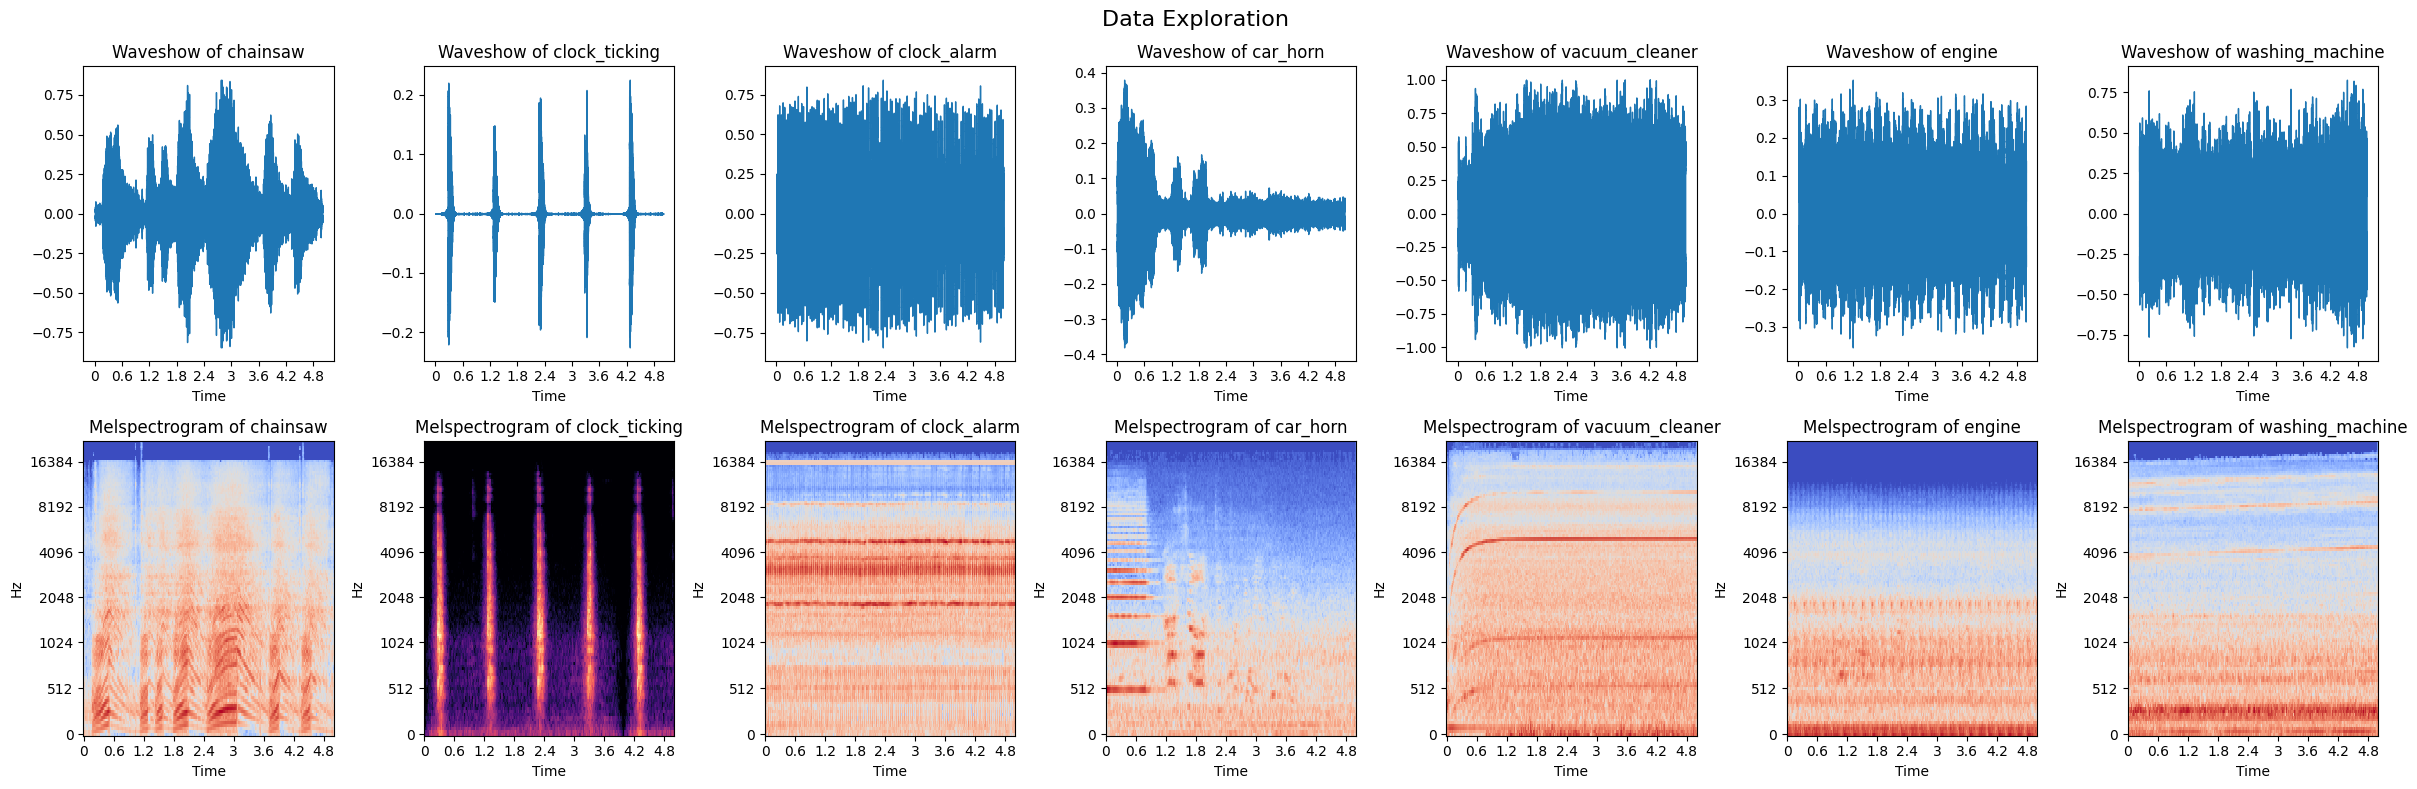

In [4]:
classes=["chainsaw","clock_ticking","clock_alarm","car_horn","vacuum_cleaner","engine","washing_machine"]
data = pd.read_csv('/content/drive/MyDrive/ESC50/esc50audio.csv')
#subset=data[data['category'] ==classes[0]]["filename"]
fig, axs = plt.subplots(nrows=2, ncols=(len(classes)))
axs = axs.flatten()
fig.suptitle('Data Exploration', fontsize=16)
fig.set_size_inches(24, 8)
files=["1-19898-B-41.wav","5-212181-A-38.wav","1-13613-A-37.wav","5-179868-A-43.wav","1-100210-A-36.wav","5-209992-A-44.wav","5-207811-B-35.wav"]
for i, afile in enumerate(files):
    # Load audio and plot waveform and melspectrogram of each class
    audio, sr = librosa.load(os.path.join('/content/drive/MyDrive/ESC50/ESC50-Mas/ESC-50/audio', afile), sr=None)
    librosa.display.waveshow(y=audio, sr=sr, x_axis='time', ax=axs[i])
    axs[i].set(title=f'Waveshow of {classes[i]}')
    mels_db = librosa.power_to_db(S=librosa.feature.melspectrogram(y=audio, sr=sr), ref=1.0)
    librosa.display.specshow(data=mels_db, sr=sr, x_axis='time', y_axis='mel', ax=axs[i+len(classes)])
    axs[i+len(classes)].set(title=f'Melspectrogram of {classes[i]}')
plt.tight_layout()
plt.show()

In [6]:
featuredata=data[['filename', 'category']]#grab only the relevant columns


,filename,category
0,1-100210-A-36.wav,vacuum_cleaner
1,1-100210-B-36.wav,vacuum_cleaner
2,1-116765-A-41.wav,chainsaw
3,1-13613-A-37.wav,clock_alarm
4,1-14262-A-37.wav,clock_alarm
5,1-17124-A-43.wav,car_horn
6,1-18527-A-44.wav,engine
7,1-18527-B-44.wav,engine
8,1-19026-A-43.wav,car_horn
9,1-19840-A-36.wav,vacuum_cleaner


In [12]:
feature_list = []
label_list = []
# Iterate over all files in given source path
print('Preparing feature dataset and labels.')
for row in tqdm(featuredata.itertuples()): #tqdm just helps visualize the loop with timers and performance/s

    # Load audio and stretch it to length 1s
    audio_path = os.path.join('/content/drive/MyDrive/ESC50/ESC50-Mas/ESC-50/audio', row.filename)
    audio, sr = librosa.load(path=audio_path, sr=None)
    audio = librosa.effects.time_stretch(y=audio, rate=len(audio)/sr)
    # Calculate features and get the label from the filename
    mels = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=555)
    mels_db = librosa.power_to_db(S=mels, ref=1.0)
    feature_list.append(mels_db.reshape((128, 16, 5))) #Use this for CNN
    #feature_list.append(mels_db.reshape((5, 2048))) #Use this for LTSM
    label_list.append(row.category)
features = np.array(feature_list)
labels = np.array(label_list)

Preparing feature dataset and labels.


280it [00:12, 22.93it/s]


In [8]:
model = keras.Sequential(layers=[ #CNN Model
        keras.layers.InputLayer(input_shape=features[0].shape),
        keras.layers.Conv2D(16, 3, padding='same', activation=keras.activations.relu),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(32, 3, padding='same', activation=keras.activations.relu),
        keras.layers.MaxPooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dense(7, activation=keras.activations.softmax)
    ])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 16, 16)       736       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 8, 16)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 8, 32)         4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 4, 32)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dropout (Dropout)           (None, 4096)              0

In [10]:
lb = LabelBinarizer()
labelz=lb.fit_transform(labels)
print(labelz) #One hot encode labels.

[[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 0]]


In [13]:
    #LTSM
    modelLTSM = keras.Sequential(layers=[
    keras.layers.InputLayer(input_shape=features[0].shape),
    keras.layers.Dense(64, activation=keras.activations.relu),
    keras.layers.LSTM(4),
    keras.layers.Dense(7, activation=keras.activations.softmax)])

modelLTSM.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
print(modelLTSM.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 5, 64)             131136    
                                                                 
 lstm (LSTM)                 (None, 4)                 1104      
                                                                 
 dense_3 (Dense)             (None, 7)                 35        
                                                                 
Total params: 132275 (516.70 KB)
Trainable params: 132275 (516.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Epoch 1/20
137/137 [==============================] - 2s 5ms/step - loss: 4.8169 - accuracy: 0.3212 - val_loss: 2.1326 - val_accuracy: 0.3898
Epoch 2/20
137/137 [==============================] - 1s 6ms/step - loss: 1.0933 - accuracy: 0.5547 - val_loss: 1.3456 - val_accuracy: 0.5424
Epoch 3/20
137/137 [==============================] - 1s 6ms/step - loss: 1.0263 - accuracy: 0.6277 - val_loss: 1.1738 - val_accuracy: 0.5593
Epoch 4/20
137/137 [==============================] - 1s 5ms/step - loss: 0.7176 - accuracy: 0.7664 - val_loss: 2.2363 - val_accuracy: 0.5932
Epoch 5/20
137/137 [==============================] - 1s 4ms/step - loss: 0.5145 - accuracy: 0.8394 - val_loss: 1.1341 - val_accuracy: 0.6441
Epoch 6/20
137/137 [==============================] - 1s 4ms/step - loss: 0.6158 - accuracy: 0.8759 - val_loss: 1.5523 - val_accuracy: 0.6102
Epoch 7/20
137/137 [==============================] - 1s 4ms/step - loss: 0.9270 - accuracy: 0.7372 - val_loss: 1.4924 - val_accuracy: 0.4915
Epoch 

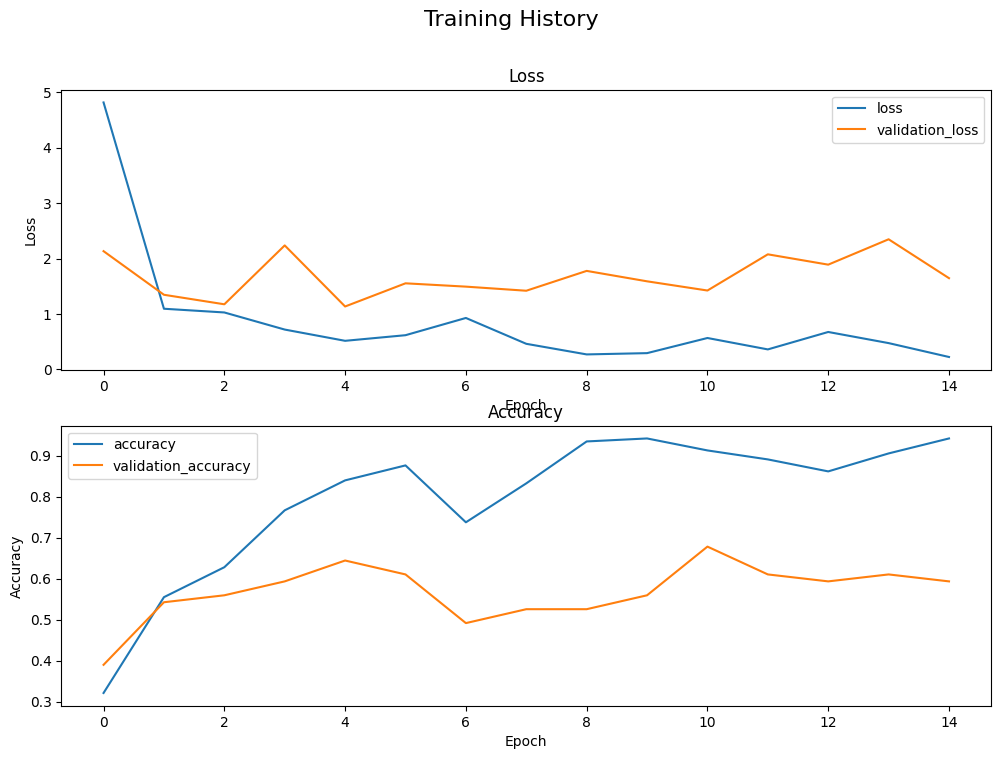

In [11]:
#Model Training and test
TEST_SIZE = 0.3
BATCH_SIZE = 1
EPOCHS = 20

# Split dataset to train and test data
X_train, X_test, y_train, y_test = train_test_split(features, labelz, test_size=TEST_SIZE)

# Train the model
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)#Early Stopping is optional
history = model.fit(x=X_train, y=y_train, validation_split=TEST_SIZE, epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=[early_stopping])
#history = modelLTSM.fit(x=X_train, y=y_train, validation_split=TEST_SIZE, epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=[early_stopping])

# Plot the training history
fig, axs = plt.subplots(2)
fig.set_size_inches(12, 8)
fig.suptitle('Training History', fontsize=16)
axs[0].plot(history.epoch, history.history['loss'], history.history['val_loss'])
axs[0].set(title='Loss', xlabel='Epoch', ylabel='Loss')
axs[0].legend(['loss', 'validation_loss'])
axs[1].plot(history.epoch, history.history['accuracy'], history.history['val_accuracy'])
axs[1].set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')
axs[1].legend(['accuracy', 'validation_accuracy'])
plt.show()

3/3 [==============================] - 0s 10ms/step
[0 6 1 5 3 0 6 4 3 6 2 5 6 6 2 1 4 0 4 2 5 1 0 6 6 3 0 4 3 2 0 0 1 2 3 1 0
 6 0 6 0 5 6 6 3 3 6 5 3 5 2 6 3 3 6 6 1 1 3 0 1 6 3 2 2 2 3 1 3 1 2 6 5 3
 2 1 1 6 6 6 6 0 3 3]


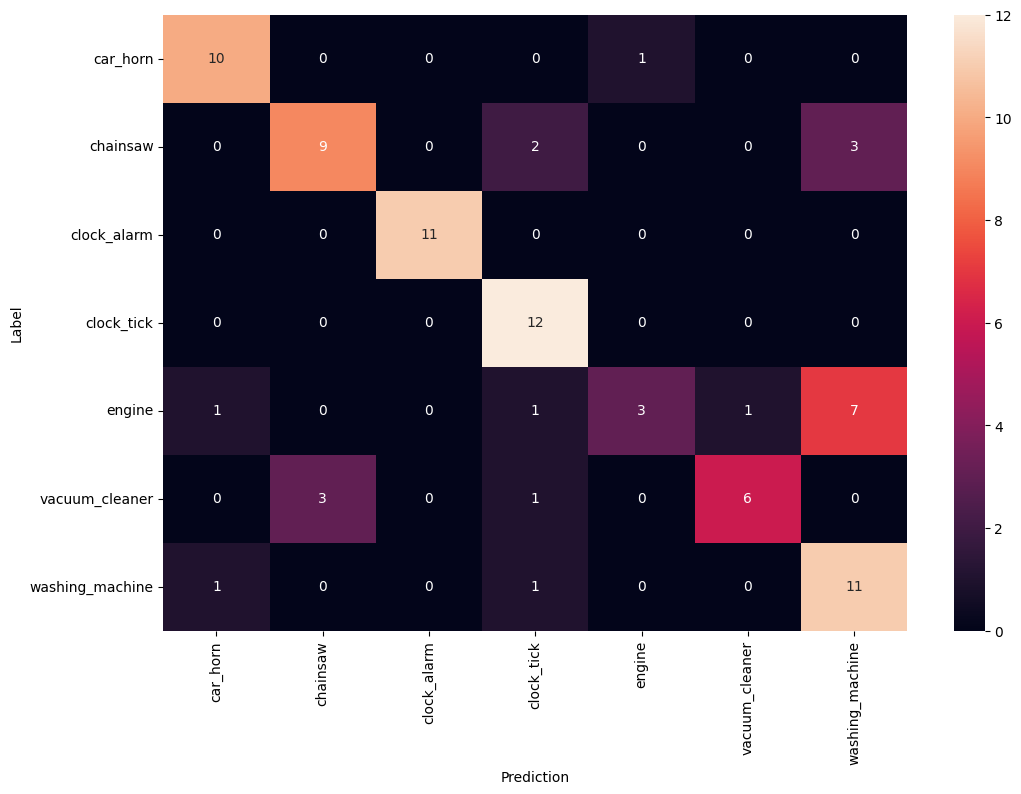

In [14]:
#Confusion Matrix
y_predicted = np.argmax(model.predict(x=X_test), axis=1)
print(y_predicted)
y_true = np.argmax(y_test, axis=1)
label_names = np.unique(labels)
confusion_matrix = tf.math.confusion_matrix(labels=y_true, predictions=y_predicted)
fig = plt.figure()
fig.set_size_inches(12, 8)
sns.heatmap(confusion_matrix, xticklabels=label_names, yticklabels=label_names, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [15]:
from sklearn.metrics import classification_report

#F1 Score etc. metrics
print(classification_report(y_predicted, y_true))

              precision    recall  f1-score   support

           0       0.91      0.83      0.87        12
           1       0.64      0.75      0.69        12
           2       1.00      1.00      1.00        11
           3       1.00      0.71      0.83        17
           4       0.23      0.75      0.35         4
           5       0.60      0.86      0.71         7
           6       0.85      0.52      0.65        21

    accuracy                           0.74        84
   macro avg       0.75      0.77      0.73        84
weighted avg       0.83      0.74      0.76        84

